In [1]:
# rewrite clean data csv

# import using updated clean data csv
# create sequential using that dataframe

# Move clean model and save data csv to a py file

In [2]:
# Checking GPU availability
from __future__ import absolute_import, division, print_function, unicode_literals #to check for gpu

# Custom libraries
from custom_libraries import file_saving
from custom_libraries import image_processing
from custom_libraries import import_data

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Images
import pydicom
import cv2

# Batching for DataGenerator
from tensorflow.python.keras.utils.data_utils import Sequence

# Keras, Tensorflow and other model related
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix

# Checking devices and system settings
import sys
print("Python: ", sys.version[:6])
print("Keras: ",keras.__version__)
print("Tensorflow: ",tf.__version__)
print("GPU Available: ",tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("\nAll devices:", *tf.config.experimental.list_physical_devices(),sep="\n")

# saving to cloud storage
from google.cloud import storage
import gcloud_storage #local py file



Using TensorFlow backend.


Python:  3.5.3 
Keras:  2.3.0
Tensorflow:  2.0.0
GPU Available:  True
Num GPUs Available:  1

All devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# Set global variables
batch_size=100
dim=(512,512)
data_path = "../data/"   # used when calling DataGenerator
random_seed = 12345


## Import and Create Data Generator

#### Import

In [6]:
train_sample2 = import_data.clean_data_csv(shuffle_data = True)

In [7]:
train_sample2_each = [
    train_sample2[train_sample2[category] ==1 ].sample(
        n=2500,
        replace = False, 
        random_state = random_seed)
    for category
    in ['epidural',
        'intraparenchymal',
        'intraventricular',
        'subarachnoid',
        'subdural']
]
train_sample2_each.append(
    train_sample2[train_sample2['any'] == 0 ].sample(
        n=2500*5,
        replace = False, 
        random_state = random_seed)
)

In [8]:
train_sample2_new = pd.concat(train_sample2_each).drop_duplicates()
train_sample2_new.reset_index(inplace = True)

In [10]:
# list(train_sample2.columns)[2:]

In [12]:
# traingen_data = train_sample2[0 : train_size].reset_index(drop=True)
validgen_data = train_sample2[0: 128*40].reset_index(drop=True)

In [13]:
# traingen=DataGenerator(traingen_data,data_path = data_path, batch_size = 128)#increase back to 100000
traingen=image_processing.DataGenerator(train_sample2_new,data_path = data_path, batch_size = 128)#increase back to 100000
validgen=image_processing.DataGenerator(validgen_data,data_path = data_path, batch_size = 128)

In [14]:
traingen_test_data = train_sample2[0: 128*5].reset_index(drop=True)
validgen_test_data = train_sample2[128*5: 128*6].reset_index(drop=True)

traingen_test=image_processing.DataGenerator(traingen_test_data,data_path = data_path, batch_size = 128)#increase back to 100000
validgen_test=image_processing.DataGenerator(validgen_test_data,data_path = data_path, batch_size = 128)

In [18]:
validgen_test_binary=image_processing.DataGenerator_single_class(validgen_test_data,data_path = data_path, batch_size = 128)

In [21]:
# validgen_test_binary[0][1]

For an unbalanced data-set it is good to define a custom loss function like the focal loss. We will borrowed the code for this from https://www.kaggle.com/xhlulu/rsna-intracranial-simple-densenet-in-keras

In [14]:
def focal_loss(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

In [20]:
model_notes = "24600 images, balanced across each category, binary, 512"
model_tags = ['binary', 'img_size:512']

Now that we have both Input=X , Category=y_test we can train a basic barebones model.
Here we have a model which is like ==   CNN -> CNN->  Flatten --> Dense ---> Dense(output)

In [16]:
# Add weighted log loss - https://www.kaggle.com/akensert/inceptionv3-prev-resnet50-keras-baseline-model

# RUN MODEL - RUN ONLY WHEN READY OR SKIP TO LOAD MODEL


# enter any notes that you want stored with this model
model_notes = model_notes
model_tags = model_tags

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(dim[0], dim[1],1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(5,5)))

model.add(Flatten())  

# model.add(Dense(100))
# model.add(Activation('relu'))

model.add(Dense(50))
model.add(Activation('relu'))

model.add(Dense(6, activation = 'sigmoid'))

# model.compile(loss='categorical_crossentropy',
# originally the above. Why use binary vs categorical

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model.compile(loss=focal_loss,
#                optimizer='adam',
#                metrics=['accuracy'])


# compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(X,y_train,batch_size=32,epochs=6,validation_split=0.5)
history=model.fit_generator(
    generator=traingen_test,
    validation_data=validgen_test,
    use_multiprocessing=True,
    workers=5,
    epochs=1)

file_saving.save_model(model, return_df=False, model_notes=model_notes)


5/5 [==============================] - 17s 3s/step - loss: 0.3974 - accuracy: 0.8938 - val_loss: 0.3363 - val_accuracy: 0.9258


## Get Predictions

In [22]:
# y_pred_temp_model = temp_model.predict_generator(
#     generator=validgen,
#     use_multiprocessing=True,
# #     batch_size = 128,
# #     steps= 2,
# #     May need batch_size and steps.
# #     If not specificied will use len(generator) which will not include the last partial batch
#     workers=5
# )

In [23]:
# y_pred_temp_model_df = pd.DataFrame(y_pred_temp_model,columns=list(validgen_data.columns)[1:])

In [42]:
def get_predictions(model, validgen):
    y_pred = model.predict_generator(
        generator=validgen,
        use_multiprocessing=True,
    #     batch_size = 128,
    #     steps= 2,
    #     May need batch_size and steps.
    #     If not specificied will use len(generator) which will not include the last partial batch
        workers=5
    )
    
    y_pred_df = pd.DataFrame(y_pred,columns=list(validgen_data.columns)[1:])
    
    return y_pred_df

In [44]:
y_pred_df = get_predictions(model,validgen_test)

In [45]:
columns = list(validgen_data.columns[1:])
for column in columns:
    y_pred_df[column + '__binary'] = y_pred_df[column].map(lambda x: 1 if x > .5 else 0)

## Confusion Matrix

In [33]:
# create a matrix of confusion matrices - each column is a column, each row is a cut-off

In [54]:
def get_confusion_matrix(y_actual,y_pred,**kwargs):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_actual,y_pred,**kwargs)
    heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues);
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('True label');
    plt.xlabel('Predicted label');


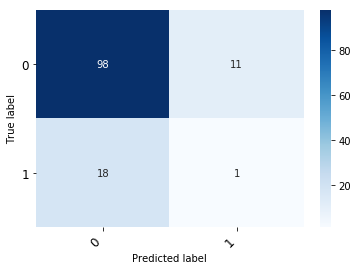

In [55]:
get_confusion_matrix(validgen_test_data['any'],y_pred_df['any__binary'])


In [ ]:
# making a prediction from a saved model

In [ ]:
model.predict()

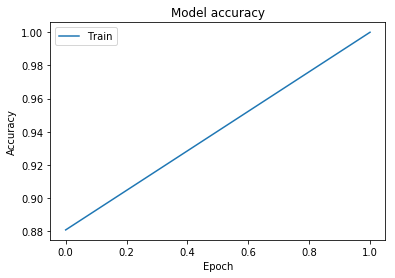

In [99]:
# plot accuracy

plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

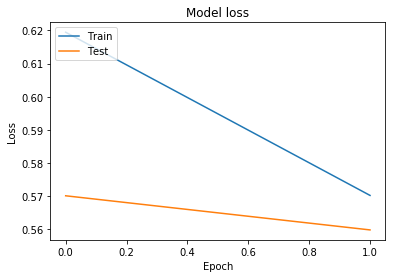

In [100]:
# plot loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [101]:
## Loading a Previous Model

In [17]:
def load_model(root = 'models/', records_output = True, model_output = False, model_file_path = ""):
    """
    
    
    """
    model_records_path = root+'model_records.csv'
    df = pd.read_csv(model_records_path)
    if not model_output:
        return df
    else:
        
        model = tf.keras.models.load_model(model_file_path)
        if records_output:
            return df, model
        else:
            return model

In [18]:
# See df of most recent records
records = load_model(records_output = True, model_output = False)
last_record = list(records.model_path)[-1]
records.tail(10)

,epochs,layers,model_name,model_notes,model_path,model_tags,num_layers,optimizer,score,timestamp,train_size,validation_size
8,1,[],2019-10-11T181803_model.h5,"test run with ~1000 images, using save_model(p...",models/2019-10-11T181803_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-11 18:18:03.877753,1,1
9,1,[],2019-10-13T224638_model.h5,test run with ~1000 images and ~200 valid size...,models/2019-10-13T224638_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-13 22:46:38.409506,1,1
10,1,[],2019-10-13T231208_model.h5,test run with ~1000 images and ~200 valid size...,models/2019-10-13T231208_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-13 23:12:08.724183,1,1
11,1,[],2019-10-14T153044_model.h5,test run with ~1000 images and ~200 valid size...,models/2019-10-14T153044_model.h5,"{'tensorflow', 'keras'}",0,1,1,2019-10-14 15:30:44.529041,1,1
12,1,[],2019-10-14T155036_model.h5,test run with ~1000 images and ~200 valid size...,models/2019-10-14T155036_model.h5,"{'tensorflow', 'keras'}",0,1,1,2019-10-14 15:50:36.173946,1,1
13,1,[],2019-10-14T174235_model.h5,test run with ~1000 images and ~200 valid size...,models/2019-10-14T174235_model.h5,"{'tensorflow', 'keras'}",0,1,1,2019-10-14 17:42:35.160266,1,1
14,1,[],2019-10-14T174315_model.h5,test run with ~1000 images and ~200 valid size...,models/2019-10-14T174315_model.h5,"{'tensorflow', 'keras'}",0,1,1,2019-10-14 17:43:15.894860,1,1
15,1,[],2019-10-14T193159_model.h5,testing,models/2019-10-14T193159_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-14 19:31:59.079340,1,1
16,1,[],2019-10-14T194331_model.h5,"24600 images, balanced across each category in...",models/2019-10-14T194331_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-14 19:43:31.080304,1,1
17,1,[],2019-10-19T020705_model.h5,test,models/2019-10-19T020705_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-19 02:07:05.253117,1,1


In [19]:
# load_model last model
_, loaded_model = load_model(records_output = True, model_output = True, model_file_path = last_record)


In [20]:
_, temp_model = load_model(records_output = True, model_output = True, model_file_path = 'models/2019-10-14T194331_model.h5')

In [ ]:
# y_pred = model.predict()

ValueError: x and y can be no greater than 2-D, but have shapes (200,) and (200, 200, 1)

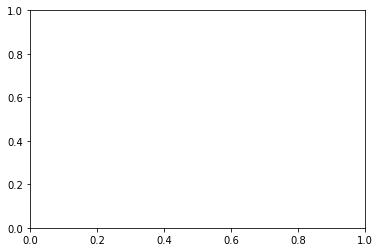

In [43]:
plt.plot(validgen[0][0][0])

# TESTING

#### Saving and loading models

In [58]:
# barebones function to save. Used for testing the save functions

model_path = 'models/2019-10-13T224638_model.h5'
# keras.models.save_model(model, model_path)
loaded_model = tf.keras.models.load_model(model_path)


In [318]:
# test = save_model(model, model_tags = [],return_df=True, model_notes="hello")
# test

worked-1
worked-2


,epochs,layers,model_name,model_notes,model_path,model_tags,num_layers,optimizer,score,timestamp,train_size,validation_size
0,1,[],2019-10-10T211053_model.h5,NaN,models/2019-10-10T211053_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:10:53.796514,1,1
1,1,[],2019-10-10T211056_model.h5,NaN,models/2019-10-10T211056_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:10:56.404866,1,1
2,1,[],2019-10-10T211112_model.h5,hello,models/2019-10-10T211112_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:11:12.708478,1,1
3,1,[],2019-10-10T211115_model.h5,hello,models/2019-10-10T211115_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:11:15.211067,1,1
4,1,[],2019-10-10T211116_model.h5,hello,models/2019-10-10T211116_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 21:11:16.248314,1,1
5,1,[],2019-10-10T211129_model.h5,hello,models/2019-10-10T211129_model.h5,"{keras, tensorflow}",0,1,1,2019-10-10 21:11:29.360498,1,1


In [286]:
# root = 'models/'
# save_as_type = 'h5' # can choose 'h5' or 'tf'
# model_records_path = root+'model_records.csv'

# df = pd.read_csv(model_records_path)
# df

,epochs,layers,model_name,model_path,model_tags,num_layers,optimizer,score,timestamp,train_size,validation_size
0,1,[],2019-10-10T202614_model.h5,models/2019-10-10T202614_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:14.109413,1,1
1,1,[],2019-10-10T202617_model.h5,models/2019-10-10T202617_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:17.506235,1,1
2,1,[],2019-10-10T202618_model.h5,models/2019-10-10T202618_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:18.759291,1,1
3,1,[],2019-10-10T202619_model.h5,models/2019-10-10T202619_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:19.641559,1,1
4,1,[],2019-10-10T202620_model.h5,models/2019-10-10T202620_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:20.819121,1,1
5,1,[],2019-10-10T202621_model.h5,models/2019-10-10T202621_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:21.808913,1,1
6,1,[],2019-10-10T202622_model.h5,models/2019-10-10T202622_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:22.799794,1,1
7,1,[],2019-10-10T202627_model.h5,models/2019-10-10T202627_model.h5,"{'keras', 'tensorflow'}",0,1,1,2019-10-10 20:26:27.330631,1,1


In [32]:
# Load model, if starting from a pre-made model
# root = 'models/'
# records_df, model = load_model(model_file_path="models/2019-10-11T004440_model.h5", model_output=True)

# from keras.initializers import glorot_uniform

# from keras.models import load_model
# from keras.utils import CustomObjectScope
# from keras.initializers import glorot_uniform
# with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
#         loaded_model = keras.models.load_model('models/2019-10-11T004440_model.h5')

# model = keras.models.load_model('models/2019-10-11T004440_model.h5',custom_objects={"GlorotUniform": keras.initializers.glorot_uniform})

# custom_objects={"GlorotUniform": tf.keras.initializers.glorot_uniform}

# from keras.models import load_model
# from keras.utils import CustomObjectScope

# with CustomObjectScope({'GlorotUniform': glorot_uniform()}):

#         model = load_model('imdb_mlp_model.h5')

# root = 'models/'

# save_as_type = 'h5' # can choose 'h5' or 'tf'
# model_records_path = root+'model_records.csv'

# df = pd.read_csv(model_records_path)
# df


#### Time

In [112]:
import time
# import datetime
from datetime import datetime

In [194]:
# d = date.today()
from datetime import datetime
d = datetime.utcnow()
d.isoformat()
d.strftime("%Y-%m-%dT%H%M%S")

'2019-10-10T195147'